# Notebook

In [1]:
import pandas as pd # pip install pandas
import numpy as np

# internal lib
import core as core

# Rendering
%matplotlib inline
import matplotlib # pip install matplotlib
import matplotlib.pyplot as plt

import plotly # pip install plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

import folium # pip install folium
from folium import plugins
from datetime import datetime

import ipywidgets as widgets
from IPython.display import display, HTML

import colorlover as cl # pip3 install colorlover

## Parameters

In [2]:
root = "../"
data_folder = root + "trip_data/"
fare_folder = root + "trip_fare/"
data_file = data_folder + "trip_data_1.csv"
fare_file = fare_folder + "trip_fare_1.csv"

nrows = None # None to use the full database

## Overview

The Goals:
    Find opportunities in the dataset

The Scope:
    Keep only tip_amount and fare_amount

Notebook structure:
* Loaded and cleaned
* Market Information
  * Temporal distribution
  * Spatial distribution
* Caracterisations - variable dependencies
* Building a model
  * A random forest prediction
  * A Linear Prediction
* Analysis by Taxi license

## Loaded and cleaned

In [3]:
full = core.load_and_clean(data_file, fare_file, nrows=nrows)

The indexing is unique, the join operation is possible
Data loading and cleaning completed


In [4]:
full.describe()

,rate_code,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
count,1.477662e+07,1.477662e+07,1.477662e+07,1.477662e+07,1.477662e+07,1.477662e+07,1.477653e+07,1.477653e+07,1.477662e+07,1.477662e+07,1.477662e+07,1.477662e+07,1.477662e+07,1.477662e+07
mean,1.034273e+00,1.697372e+00,6.834236e+02,2.770976e+00,-7.263634e+01,4.001440e+01,-7.259443e+01,3.999219e+01,1.166472e+01,3.204904e-01,4.983970e-01,1.267509e+00,2.018670e-01,1.395298e+01
std,3.387715e-01,1.365396e+00,4.944063e+02,3.305923e+00,1.013819e+01,7.789904e+00,1.028860e+01,7.537067e+00,9.639219e+00,3.675741e-01,2.826541e-02,2.046084e+00,1.035481e+00,1.146469e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.771285e+03,-3.547921e+03,-2.350956e+03,-3.547921e+03,2.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+00
25%,1.000000e+00,1.000000e+00,3.600000e+02,1.000000e+00,-7.399188e+01,4.073551e+01,-7.399121e+01,4.073468e+01,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,7.700000e+00
50%,1.000000e+00,1.000000e+00,5.540000e+02,1.700000e+00,-7.398166e+01,4.075315e+01,-7.398013e+01,4.075362e+01,9.000000e+00,0.000000e+00,5.000000e-01,8.000000e-01,0.000000e+00,1.050000e+01
75%,1.000000e+00,2.000000e+00,8.850000e+02,3.060000e+00,-7.396684e+01,4.076729e+01,-7.396390e+01,4.076819e+01,1.300000e+01,5.000000e-01,5.000000e-01,2.000000e+00,0.000000e+00,1.550000e+01
max,2.100000e+02,2.550000e+02,1.080000e+04,1.000000e+02,1.124042e+02,3.310365e+03,2.228738e+03,3.477106e+03,5.000000e+02,1.250000e+01,5.000000e-01,2.000000e+02,2.000000e+01,6.500000e+02


## Market Information

An important information directly available in the dataset is the market size and its distribution (temporal and spacial)

In [5]:
display(HTML("Market size of the full month: ${:,}".format(int(full["total_amount"].sum()))))

We are particularly interested by the repartition, hence the goal is to find some opportunities in the market.

### Temporal distribution

The visualization below show a repetitive pattern of the taxi offer. The Sundays are different in the way that the demand/offer is less important than other days but the pattern is really stable. (TODO check with a standard deviation and autocorrelation)

In [6]:
resample_columns = ["fare_amount", "surcharge", "mta_tax", "tip_amount", "tolls_amount", "total_amount"]
hour_sample = core.resample_on_subset(full, resample_columns, "H", np.sum)
minute_sample = core.resample_on_subset(full, resample_columns, "10T", np.sum)

In [7]:
selection = "total_amount" # choose something in the resample_columns list
core.plot_time_series(hour_sample[selection], minute_sample[selection])

### Spatial distribution

In this heatmap visualisation, it clearly appears that Manhattan and JFK airport are the busiest locations

Please select a date and a specific hour to visualize the stability toward time. You can also select another criteria to display like tips or tolls

In [8]:
date = pd.to_datetime("2013-01-13T09:00:00")
selection = "total_amount" #"tolls_amount"

In [9]:
# Warning, Chrome restriction to 66k point for the heatmap. The viz is limited to a few hours scope
df = full.loc[(
    (full.index.get_level_values('pickup_datetime').day == date.day) &
    (full.index.get_level_values('pickup_datetime').hour == date.hour))]
core.heatmap(df, lat_col='pickup_latitude', lon_col='pickup_longitude', \
    zoom_start=11, heat_map_weights_col=selection, heat_map_radius=10)

## Caracterisations - variable dependencies

The datasest is reducted to one day and one hour, it is completely sufficient.

Remarks
* A linear model for fare_amount is possible for each rate_code groups
* For negociated fares, the distance seems to be disable (in the future, those points should be remove to don't perturb the model)
* The dataset contains may contain multiple errors (evidence on the previous map ^^)
* JFK fare is constant

In [10]:
names = ["Standard rate", "JFK", "Newark", "Nassau or Westchester", "Negotiated fare", "Groups"]
groups = full.loc[(
    (full.index.get_level_values('pickup_datetime').day == date.day) & 
    (full.index.get_level_values('pickup_datetime').hour == date.hour))].groupby("rate_code")
display(HTML("Total number of points {}. Try to keep the total number of pints below 100k".format(groups.size().sum())))

In [37]:
x_selection = "trip_distance"
y_selection = "fare_amount"
core.scatter_on_groups_2D(groups, x_selection, y_selection, group_names=names)

In [12]:
# 3D display is also possible but quite heavy for a notebook. Enable it for small clouds of points ...
data = []
x_selection = "trip_distance"
y_selection = "trip_time_in_secs"
z_selection = "fare_amount"
core.scatter_on_groups_3D(groups, x_selection, y_selection, z_selection, group_names=names)

## Building a model

### A random forest prediction

Due to categorical variable, a random forest regressor can be appropriated

In [13]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import warnings

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



In [14]:
# Function that train a random forest classifier with the specific parameters passed in argument. 
# It returns the training data set X, the labels y, the prediction y_pred and the classifier used.
def random_forest_predict(df, to_predict, parameters, n_estim=10, max_dep=2):
    X = df[parameters]
    y = df[to_predict]
    classifier = RandomForestRegressor(n_estimators=n_estim, max_depth=max_dep)
    classifier.fit(X,y)

    y_pred = classifier.predict(X)
    return X, y, y_pred, classifier

scoring = 'explained_variance'
def score(y, y_pred):
    return metrics.explained_variance_score(y, y_pred)

In [38]:
df = full.loc[(
    (full.index.get_level_values('pickup_datetime').day == date.day))].reset_index(drop=True)
df = df[df["rate_code"] != 5]
df["hour"] = df["pickup_datetime"].dt.hour
parameters = ["rate_code", "passenger_count", "trip_time_in_secs", "trip_distance", "pickup_longitude", "pickup_latitude", "hour"]
to_predict = "fare_amount"
X, y, y_pred, classifier = random_forest_predict(df, to_predict, parameters, n_estim=20, max_dep=6)

print('The accuracy is {0:.1f}%'.format(score(y, y_pred)*100))

The accuracy is 29.1%


In [39]:
cross_validation = cross_validate(classifier, X, y, cv=10, scoring=scoring)

In [40]:
pd.Series(cross_validation["test_score"]).describe()

count    10.000000
mean     -8.891311
std      28.716033
min     -90.613637
25%      -0.023726
50%       0.264665
75%       0.312258
max       0.541508
dtype: float64

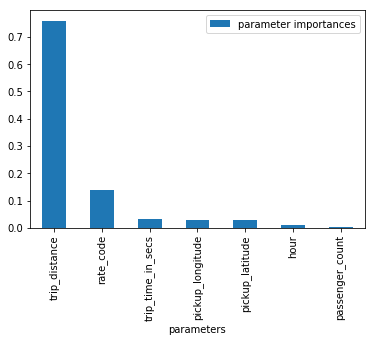

In [41]:
# Plot the list of parameters 
df_parameters_importances = pd.DataFrame({"parameters": parameters, "parameter importances": classifier.feature_importances_})
df_parameters_importances = df_parameters_importances.set_index("parameters")
df_parameters_importances = df_parameters_importances.sort_values("parameter importances", ascending=False)
df_parameters_importances.plot(kind="bar");

### A Linear Prediction

In [45]:
from sklearn.linear_model import Ridge, LinearRegression
def ridge_predict(df, to_predict, parameters, alpha=1.0):
    X = df[parameters]
    y = df[to_predict]
    classifier = LinearRegression()
    classifier.fit(X,y)

    y_pred = classifier.predict(X)
    return X, y, y_pred, classifier

In [46]:
X, y, y_pred, classifier = ridge_predict(df, to_predict, parameters)

print('The accuracy is {0:.1f}%'.format(score(y, y_pred)*100))

The accuracy is 23.8%


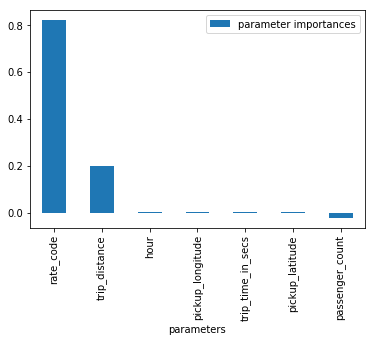

In [47]:
df_parameters_importances = pd.DataFrame({"parameters": parameters, "parameter importances": classifier.coef_})
df_parameters_importances = df_parameters_importances.set_index("parameters")
df_parameters_importances = df_parameters_importances.sort_values("parameter importances", ascending=False)
df_parameters_importances.plot(kind="bar");

Separation of linear models

In [22]:
# Select one rate_code
Selection = 1

In [23]:
X, y, y_pred, classifier = ridge_predict(df[df["rate_code"] == 4], "fare_amount", parameters)

print('The accuracy is {0:.1f}%'.format(score(y, y_pred)*100))

The accuracy is 94.0%


## Analysis by Taxi license

Here, we will try to identify the most prolific taxi licenses 

In [24]:
col = ['dropoff_datetime', \
       'trip_time_in_secs', 'trip_distance', \
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', \
       'dropoff_latitude', 'fare_amount', \
       'tip_amount', 'total_amount', \
       'hack_license', 'pickup_datetime']
grouped = full[col].reset_index(drop=True).groupby(["hack_license"])#, df.pickup_datetime.dt.day])

In [25]:
taxis = grouped.agg([np.sum, np.median, np.mean, np.std, np.min, np.max, 'count'])

In [26]:
mean = taxis[('trip_distance', 'count')].mean()
mean

458.5593036246276

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1479caeb8>]],
      dtype=object)

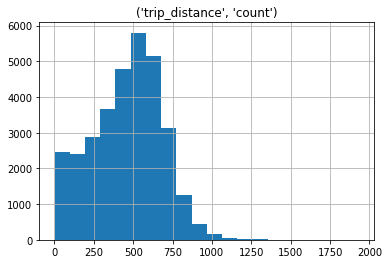

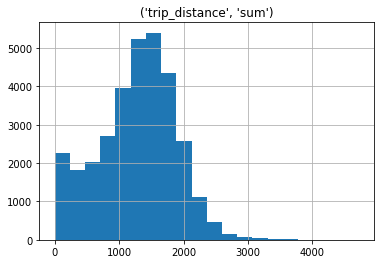

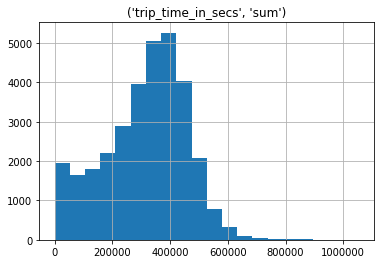

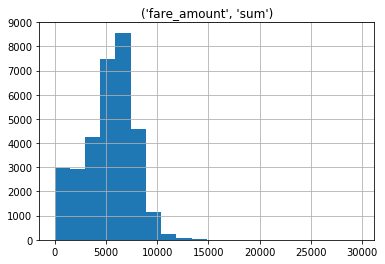

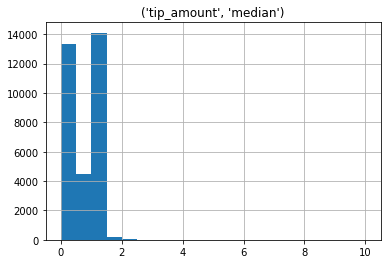

In [27]:
taxis.hist(('trip_distance', 'count'), bins=20)
taxis.hist(('trip_distance', 'sum'), bins=20)
taxis.hist(('trip_time_in_secs', 'sum'), bins=20)
taxis.hist(('fare_amount', 'sum'), bins=20)
taxis.hist(('tip_amount', 'median'), bins=20, range=(0,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1657d6c88>]],
      dtype=object)

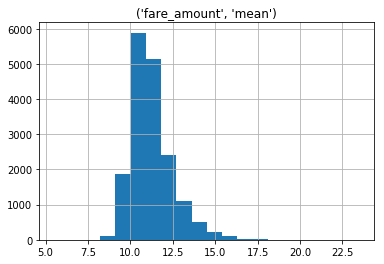

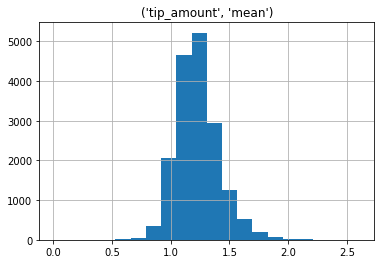

In [28]:
t2 = taxis[taxis[('trip_distance', 'count')] > taxis[('trip_distance', 'count')].mean()]
t2.hist(('fare_amount', 'mean'), bins=20)
t2.hist(('tip_amount', 'mean'), bins=20)

In [29]:
t3 = t2[t2[('tip_amount', 'mean')] > 2]

In [30]:
t3.index.values.shape

(26,)

In [31]:
big = full[full.index.isin(list(t3.index.values), level=1)]

In [32]:
core.heatmap(big[:], lat_col='pickup_latitude', lon_col='pickup_longitude', \
    zoom_start=11, heat_map_weights_col=selection, heat_map_radius=10)

In [53]:
hour = big.groupby(big.index.get_level_values('pickup_datetime').hour).mean()
hour_full = full.groupby(full.index.get_level_values('pickup_datetime').hour).mean()

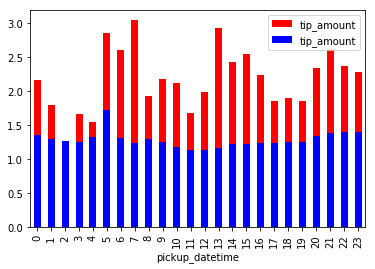

In [57]:
ax = hour[["tip_amount"]].plot(kind='bar', color='r')
hour_full[["tip_amount"]].plot(kind='bar', color='b', ax=ax)

Taxi licenses with biggest tips are successful from 5 to 7 am and at 1pm